# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Изменим тип поля calls и messages на int, потому что дробных звонков и сообщений быть не может

In [5]:
df.calls = df.calls.astype('int64')
df.messages = df.messages.astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [6]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [7]:
df.duplicated().sum()

0

In [8]:
df.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

Датасет имеет 5 столбцов и 3214 строк. Пропусков нет! Столбцы:

- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Типы данных соответствуют.

## Разбейте данные на выборки

In [9]:
df.is_ultra.value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Разобьём данные на обучающую, тестовую, валидационную выборки в соотношении 3:1:1.

In [10]:
df_train, df_other = train_test_split(df, test_size=.25, random_state=12345)
df_test, df_valid = train_test_split(df_other, test_size=.5, random_state=12345)
print('Размер обучающей выборки', df_train.shape) # 75% 
print('Размер тестовой выборки', df_test.shape) # 12.5% 
print('Размер валидационной выборки', df_valid.shape) #12.5 

Размер обучающей выборки (2410, 5)
Размер тестовой выборки (402, 5)
Размер валидационной выборки (402, 5)


In [11]:
#для обучающей выборки
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']
#для тестовой выборки
features_test = df_test.drop('is_ultra', axis=1)
target_test = df_test['is_ultra']
#для валидационной выборки
features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

#предпросмотр
features_train.head()

,calls,minutes,messages,mb_used
101,107,804.97,66,17935.91
1915,69,429.68,28,17314.66
88,48,331.33,0,8000.36
1348,69,528.67,47,22323.98
2264,51,310.77,22,24936.54


После того как мы разбили наши данные на соотношение 3:1:1(3 - обучающая выборка, 1 - тестовая выборка, 1 - валидационная выборка), а так же разбили на признаки и целевые признаки, то перейдём к выбору модели и исследования качества выбранной модели.

## Исследуйте модели

Используем три основные модели: дерево решений, случайный лес и логистическую регрессию.

### Дерево решений

In [12]:
for depth in range(1,30,2):
    model_tree = DecisionTreeClassifier(random_state=1234, max_depth=depth)  
    model_tree.fit(features_train,target_train)  
    prediction_tree = model_tree.predict(features_valid) 
    print('max_depth:',depth, end='')
    print(' accuracy:', accuracy_score(prediction_tree,target_valid))

max_depth: 1 accuracy: 0.736318407960199
max_depth: 3 accuracy: 0.7786069651741293
max_depth: 5 accuracy: 0.763681592039801
max_depth: 7 accuracy: 0.7835820895522388
max_depth: 9 accuracy: 0.7960199004975125
max_depth: 11 accuracy: 0.8009950248756219
max_depth: 13 accuracy: 0.7711442786069652
max_depth: 15 accuracy: 0.7562189054726368
max_depth: 17 accuracy: 0.753731343283582
max_depth: 19 accuracy: 0.7213930348258707
max_depth: 21 accuracy: 0.7338308457711443
max_depth: 23 accuracy: 0.7189054726368159
max_depth: 25 accuracy: 0.7164179104477612
max_depth: 27 accuracy: 0.6965174129353234
max_depth: 29 accuracy: 0.6965174129353234


При max_depth = 11 (лучшие значения гиперпараметров), качество модели "дерево предсказания" = 0.8009

### Случайный лес

In [13]:
for estim in range(1,50,2):    
    model_forest = RandomForestClassifier(max_depth=10, n_estimators=estim, random_state=1234, min_samples_leaf=5)
    model_forest.fit(features_train,target_train) 
    prediction_forest = model_forest.predict(features_valid)
    print('n_estimators:', estim, end="")
    print(' accuracy:', accuracy_score(prediction_forest, target_valid))

n_estimators: 1 accuracy: 0.7810945273631841
n_estimators: 3 accuracy: 0.7935323383084577
n_estimators: 5 accuracy: 0.7860696517412935
n_estimators: 7 accuracy: 0.7935323383084577
n_estimators: 9 accuracy: 0.7960199004975125
n_estimators: 11 accuracy: 0.7960199004975125
n_estimators: 13 accuracy: 0.8034825870646766
n_estimators: 15 accuracy: 0.8009950248756219
n_estimators: 17 accuracy: 0.8009950248756219
n_estimators: 19 accuracy: 0.8034825870646766
n_estimators: 21 accuracy: 0.8059701492537313
n_estimators: 23 accuracy: 0.8059701492537313
n_estimators: 25 accuracy: 0.8059701492537313
n_estimators: 27 accuracy: 0.8109452736318408
n_estimators: 29 accuracy: 0.8059701492537313
n_estimators: 31 accuracy: 0.8059701492537313
n_estimators: 33 accuracy: 0.8059701492537313
n_estimators: 35 accuracy: 0.8084577114427861
n_estimators: 37 accuracy: 0.8109452736318408
n_estimators: 39 accuracy: 0.8109452736318408
n_estimators: 41 accuracy: 0.8109452736318408
n_estimators: 43 accuracy: 0.8134328358

При max_depth= 10, max_samples_leaf=5 и n_estimators= 43 (лучшее значение), качество модели "случайный лес" = 0.8134

### Логистическая регрессия

In [14]:
model_lp = LogisticRegression()  
model_lp.fit(features_train, target_train)  
predict_lp = model_lp.predict(features_valid)  
print('accuracy:', accuracy_score(predict_lp, target_valid))

accuracy: 0.7039800995024875


качество модели Логистическая регрессия хуже всего = 0.7039

Лучшей моделью по метрике accuracy оказалась модель Случайный лес

## Проверьте модель на тестовой выборке

### Тест модели "Дерево предсказаний"

Дерево - 0.7064676616915423
Случайный лес - 0.8034825870646766
ЛогРегр - 0.7039800995024875


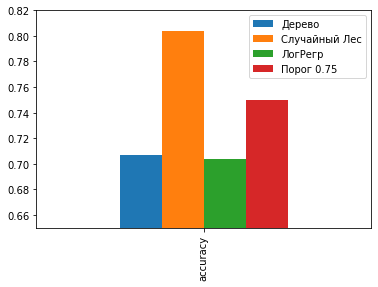

In [15]:
model_forest = RandomForestClassifier(random_state=12345,\
                                      criterion='gini',\
                                      n_estimators=15,\
                                      max_depth=10,\
                                      max_features = 'auto'\
                                     )

model_forest.fit(features_train, target_train)
predictions = model_forest.predict(features_test)
model_tree.score(features_test, target_test)
model_forest.score(features_test, target_test)
model_lp.score(features_test, target_test)
pd.DataFrame({'Дерево': [model_tree.score(features_test, target_test)],\
              'Случайный Лес': [model_forest.score(features_test, target_test)],\
              'ЛогРегр': [model_lp.score(features_test, target_test)],\
              'Порог 0.75' :[0.75]
             }, index=['accuracy']).plot.bar(ylim=(.65,.82));
print(f'Дерево - {model_tree.score(features_test, target_test)}')
print(f'Случайный лес - {model_forest.score(features_test, target_test)}')
print(f'ЛогРегр - {model_lp.score(features_test, target_test)}')

Как и предполагалось, модель на основе Случайного леса дает лучший результат - 0.8034, что выше порогового значения на  5%.  

## (бонус) Проверьте модели на адекватность

Проверим, даст ли случайное заполнение результат выше чем при модели Случайного леса.

In [16]:
predictions = pd.Series(1, index=target_test.index)
accuracy = round(accuracy_score(target_test, predictions), 4)
accuracy - model_forest.score(features_test, target_test)

-0.4999825870646766

In [17]:
predictions = pd.Series(0, index=target_test.index)
accuracy = round(accuracy_score(target_test, predictions), 4)
accuracy - model_forest.score(features_test, target_test)

-0.10698258706467656

In [18]:
predictions = pd.Series(1, index=target_test.index)
predictions[202:]=0
accuracy = round(accuracy_score(target_test, predictions), 4)
accuracy - model_forest.score(features_test, target_test)

-0.2959825870646766

Тест на адекватность пройден, т.к. сравнение было было с случайным заполнением все перешли ну тариф ultra, затем на smart, затем на 50/50 и модельное заполнение лучше заполняет по сравнению со случайным.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75


Для классификации пользователей по тарифам и предложения им перехода на тот или иной тариф - лучше всего применять модель Случайный лес. Также относительно неплохо показывает себя модель Дерево принятия решений. Логистическая регрессия показала себя недостаточно хорошо, применять для данной задлачи их не стоит. 